In [1]:
import MetaTrader5 as mt5 
import pandas as pd 
import numpy as np
from collections import deque
from datetime import datetime

import matplotlib.pyplot as plt 

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics  import f1_score, accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


NORMAL_VALUE = 19
ACCOUNT = input() # your account  
PASSWORD = int(input())  # your password
TICKER_NAME = "AUDCAD"
SERVERNAME = "Alpari-MT5-Demo"
TIME_START = datetime(2022, 11, 20)
TIME_END = 1690482014


pd.options.mode.chained_assignment = None

if not mt5.initialize():
    print(f"The Error is ,{mt5.last_error()} \n")

login_account = mt5.login(ACCOUNT, password=PASSWORD, server=SERVERNAME)
if login_account:
    print(f"Succesfully connected... version's {mt5.__version__}") # my version is 5.0.37
else:
    print(f"Connection failed. Error, {mt5.last_error()}")


df = pd.DataFrame(mt5.copy_rates_range(TICKER_NAME, 
                                      mt5.TIMEFRAME_H1,
                                      TIME_START,
                                      TIME_END)
                 )  

df.drop(["tick_volume", "real_volume", 
         "spread", "high", "low", "time"], axis=1, inplace=True)
df.head()

Succesfully connected... version's 5.0.37


,open,close
0,0.89091,0.89273
1,0.89268,0.89391
2,0.89391,0.89197
3,0.89196,0.89186
4,0.89187,0.89077


In [2]:
def ReadPositiveNegetive(file_name):
    with open(file_name, 'r') as read:
        lst = read.read()[1:-1].replace('[', '').replace(']', '').split(',')

    indexes = []
    cnt = 0
    for i in lst:    
        indexes.append(int(i.strip()[1:-1]))


    indexes = sorted(indexes)[2:]
    tow_index = []
    for i in range(0, len(indexes), 2):
        tow_index.append(indexes[i:i+2])
    
    return len(tow_index), tow_index



ind_negetive, index_negetive = ReadPositiveNegetive('DataSetNegetive.txt')
ind_positive, index_positive = ReadPositiveNegetive('DataSetPositive.txt')

In [3]:
"Postive : ", index_negetive, "Negetive : ", index_negetive

('Postive : ',
 [[244, 263],
  [370, 389],
  [427, 446],
  [564, 583],
  [606, 625],
  [748, 767],
  [987, 1006],
  [1123, 1142],
  [1243, 1262],
  [1372, 1391],
  [1391, 1410],
  [1454, 1473],
  [1628, 1647],
  [2025, 2044],
  [2082, 2101],
  [2109, 2128],
  [2266, 2285],
  [2289, 2308],
  [2316, 2335],
  [2571, 2590],
  [2705, 2724],
  [2988, 3007],
  [3586, 3605],
  [3613, 3632],
  [3657, 3676],
  [4086, 4105]],
 'Negetive : ',
 [[244, 263],
  [370, 389],
  [427, 446],
  [564, 583],
  [606, 625],
  [748, 767],
  [987, 1006],
  [1123, 1142],
  [1243, 1262],
  [1372, 1391],
  [1391, 1410],
  [1454, 1473],
  [1628, 1647],
  [2025, 2044],
  [2082, 2101],
  [2109, 2128],
  [2266, 2285],
  [2289, 2308],
  [2316, 2335],
  [2571, 2590],
  [2705, 2724],
  [2988, 3007],
  [3586, 3605],
  [3613, 3632],
  [3657, 3676],
  [4086, 4105]])

In [4]:
def ReadNeutral(file_name):
    with open(file_name, 'r') as read:
        lst = read.read()[1:-1].replace('[', '').replace(']', '').split(',')
        
    indexes = []
    for i in lst:    
        indexes.append([int(i.strip())-NORMAL_VALUE, int(i.strip())])

    return len(sorted(indexes)[1:]), sorted(indexes)[1:]
    

ind_neutral, index_netral = ReadNeutral('DataSetNeutal.txt')

In [5]:
"Netural: ", index_netral

('Netural: ',
 [[18, 37],
  [89, 108],
  [306, 325],
  [465, 484],
  [851, 870],
  [1163, 1182],
  [1417, 1436],
  [1429, 1448],
  [1528, 1547],
  [1865, 1884],
  [1915, 1934],
  [2150, 2169],
  [2203, 2222],
  [2341, 2360],
  [2514, 2533],
  [2593, 2612],
  [2758, 2777],
  [2776, 2795],
  [3004, 3023],
  [3082, 3101],
  [3116, 3135],
  [3134, 3153],
  [3202, 3221],
  [3264, 3283],
  [3354, 3373],
  [3795, 3814],
  [3837, 3856]])

In [6]:
f'Data Must be balanced so the length must near together... {ind_neutral, ind_positive, ind_negetive}'

'Data Must be balanced so the length must near together... (27, 24, 26)'

In [7]:
# New We must append index of data to main_df dataframe
def DataSetTogether(df, index, target):
    all_data = []
    for ind in index:
        data = []
        for val in df.loc[ind[0]:ind[1]-1].values:
            data.append(val[0])
            data.append(val[1])
        
        if len(data)==38:
            data.append(target)
        
        if 40>len(data)>36:
            all_data.append(data)
        
    return all_data



neg_data = DataSetTogether(df, index_negetive, -1)
neu_data = DataSetTogether(df, index_netral, 0)
pos_data = DataSetTogether(df, index_positive, 1)

dataset = [neg_data, neu_data, pos_data]

In [8]:
X = []
y = []
for j in dataset:
    for i in j:
        X.append(i[:-1])
        y.append(i[-1])
        
X, y = np.array(X), np.array(y)

In [9]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, random_state=2)
print(f"Shape of X_train {X_train.shape}")
print(f"Shape of the Y_train {y_train.shape}")
print(f"Shape of the X_valid {X_test.shape}")
print(f"Shape of the Y_valid {y_test.shape}")

Shape of X_train (72, 38)
Shape of the Y_train (72,)
Shape of the X_valid (2, 38)
Shape of the Y_valid (2,)


In [10]:
model = RandomForestClassifier(n_estimators=150, n_jobs=-1)
model.fit(X, y)

pred = model.predict(X_test)
 
print(accuracy_score(y_test, pred) * 100)
print(mean_absolute_error(y_test, pred))
print(mean_absolute_error(y_test, pred))

100.0
0.0
0.0


In [127]:
model = LogisticRegression()
model.fit(X, y)

pred = model.predict(X_test)
 
print(accuracy_score(y_test, pred) * 100)
print(mean_absolute_error(y_test, pred))
print(mean_absolute_error(y_test, pred))

50.0
0.5
0.5


In [132]:
# the RandomForestClassifier is better choise

In [128]:
df_test = pd.DataFrame(mt5.copy_rates_range('EURUSD', 
                                      mt5.TIMEFRAME_H1,
                                      datetime(2023, 7, 10),
                                      TIME_END)
                 )  

df_test.drop(["tick_volume", "real_volume", 
         "spread", "high", "low", "time"], axis=1, inplace=True)

df_test['flag'] = np.NaN
df_test.tail()

,open,close,flag
326,1.11373,1.11385,NaN
327,1.11385,1.10592,NaN
328,1.10589,1.10078,NaN
329,1.10079,1.09919,NaN
330,1.09919,1.09969,NaN


In [129]:
indx_buy = []
buy = []
indx_sell = []
sell = []
for indx in range(0, len(df_test), NORMAL_VALUE):
    test = []
    for val in df_test.iloc[indx:indx+NORMAL_VALUE].values:
        test.append(val[0])
        test.append(val[1])
    
    try:
        test = scaler.fit_transform(np.array(test).reshape(-1, 1))
        forcast = model.predict(test.reshape(1, -1))
        if forcast==1:
            df_test['flag'].iloc[indx] = forcast
            buy.append(df_test['close'].iloc[indx+2])
            indx_buy.append(indx+2)
            
        elif forcast==-1:
            df_test['flag'].iloc[indx] = forcast
            sell.append(df_test['close'].iloc[indx+2])
            indx_sell.append(indx+2)
            
    except Exception as e:
        print(e)
    
        

X has 16 features, but LogisticRegression is expecting 38 features as input.


In [130]:
def chandlesPlot(d, o, c):
    plt.figure(figsize=(24, 14))
    color = []
    for open_p, close_p in zip(o, c):
        if open_p<close_p:
            color.append("g")
        else:
            color.append("r")

    plt.bar(d, height=np.abs(o-c), 
            width=0.8, 
            color=color, 
            bottom=np.min((o, c), axis=0))


def ShowData(main_df):
    chandlesPlot(main_df.index, 
                 main_df["open"], 
                 main_df["close"])
    
    plt.scatter(indx_buy, buy, color='g', linewidths=15)
    plt.scatter(indx_sell, sell, color='r', linewidths=15)  

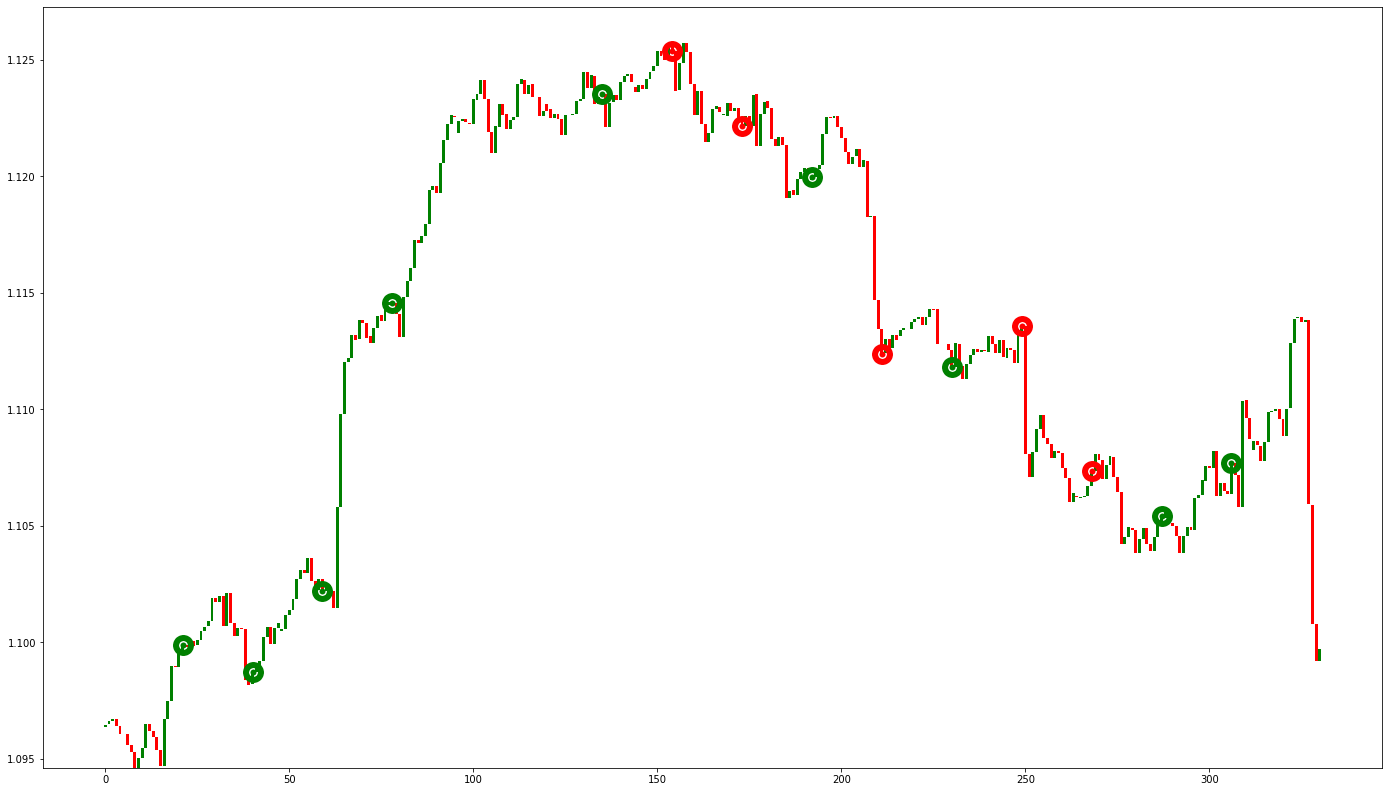

In [131]:
ShowData(df_test)